In [1]:
from utils import find_steepest_descent, loadMap, plotFigure
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import alphashape

/home/johannus/anaconda3/envs/avrenningarokid/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#bounds = (-7.0277, 61.380, -6.6362, 61.656) # Suðuroy
#bounds = (-6.351157171442581, 62.30967342287517, -6.2411181682078976, 62.360487093395776) # Fugloy
bounds = (-8, 59, -5, 64)
file_path = 'FO_DSM_2017_FOTM_10M.tif'

In [3]:
image_array, img_pil = loadMap(file_path, bounds)

In [4]:
image_array, img_pil = loadMap(file_path, bounds)
height, width = image_array.shape

grid_size = 200

paths = []
grid_x = np.linspace(0, image_array.shape[0] - 1, grid_size)
grid_y = np.linspace(0, image_array.shape[1] - 1, grid_size)

start_positions = [(int(x), int(y)) for x in grid_x for y in grid_y]

for x in grid_x:
    for y in grid_y:
        start_pos = (int(x), int(y))
        path = find_steepest_descent(image_array, start_pos, max_radius=40)
        if len(path) > 1:
            paths.append(path)


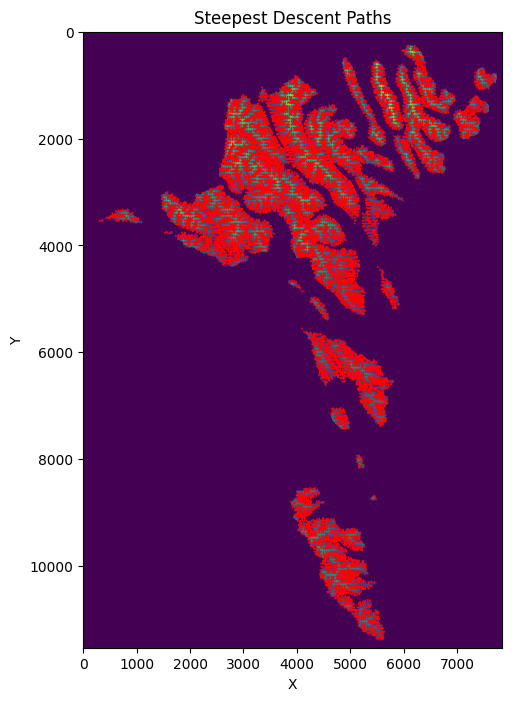

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Flip the image vertically and horizontally to correct the orientation
ax.imshow(image_array, extent=[0, width, height, 0])

# Loop through each path and plot it
for path in paths:
    path = np.array(path)  # Convert path to numpy array for easier handling
    ax.plot(path[:, 1], path[:, 0], color='red', linewidth=1)  # path[:, 1] for x, path[:, 0] for y

# Optionally, set axis labels or title
ax.set_title('Steepest Descent Paths')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()



In [6]:
path_lengths = [len(path) for path in paths]

# Replicate end points based on path lengths
weighted_end_points = []
original_end_points = []
for path, length in zip(paths, path_lengths):
    weighted_end_points.extend([path[-1]] * length)
    original_end_points.append(path[-1])

weighted_end_points = np.array(weighted_end_points)
original_end_points = np.array(original_end_points)

In [7]:
n_clusters = 6
range_in_meters=100

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming weighted_end_points and original_end_points are provided

# Step 1: Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(weighted_end_points)
kmeans_labels = kmeans.predict(original_end_points)  # Label the original end points

# Parameters
representative_points = []

# Plot background image and contours
plt.figure(figsize=(20, 12))
plt.imshow(img_pil, aspect='equal')
contour_levels = [0, 100, 150, 200, 250, 300]
plt.contour(image_array, levels=contour_levels, colors='black', linewidths=1, origin='image')
plt.gca().invert_yaxis()  # Adjust axis if necessary depending on data orientation
plt.axis('off')  # Turn off the axis

# Step 2: Loop through each cluster and find the representative paths
unique_labels = set(kmeans_labels)
for k, col in zip(unique_labels, plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))):
    class_member_mask = (kmeans_labels == k)  # Get mask for current cluster
    cluster_end_points = original_end_points[class_member_mask]  # Get end points for this cluster
    cluster_paths = [paths[i] for i in range(len(paths)) if class_member_mask[i]]  # Get paths in this cluster

    # Calculate the distance matrix for end points in the cluster
    distances = np.linalg.norm(cluster_end_points[:, np.newaxis] - cluster_end_points, axis=2)
    
    # Find the point with the minimum sum of distances to all other points (closest to most others)
    sum_distances = distances.sum(axis=1)
    nearest_index = np.argmin(sum_distances)  # Get the index of the "central" end point
    
    representative_point = cluster_end_points[nearest_index]
    representative_points.append(representative_point)
    
    # Plot the clustered end points with colors
    xy = cluster_end_points
    #plt.plot(xy[:, 1], xy[:, 0] * -1 + height, 'o', markerfacecolor=col,markeredgecolor='k', markersize=4, alpha=0.6)

# Step 3: Plot paths and calculate the number of paths within the range
path_assigned_to_cluster = np.zeros(len(paths), dtype=bool)
for k, col in zip(unique_labels, plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))):
    representative_point = representative_points[k]
    cluster_start_points_k = 0
    for path_index, path in enumerate(paths):
        end_point = path[-1]  # Get the last point of the path (end point)
        distance = np.linalg.norm(end_point - representative_point)  # Distance to representative point
        x_coords = [coord[1] for coord in path]
        y_coords = [coord[0] * -1 + height for coord in path]
        if distance <= range_in_meters / 10:  # Example: 100 meters (10 in 10x10 meter grid)
            plt.plot(x_coords, y_coords, color=col, alpha=0.6)
            path_assigned_to_cluster[path_index] = True
            cluster_start_points_k += 1
        else:
            plt.plot(x_coords, y_coords, 'black', alpha=0.01)

# Step 4: Plot the final representative points
for representative_point in representative_points:
    plt.plot(representative_point[1], representative_point[0] * -1 + height, 'o', markerfacecolor='red',
             markeredgecolor='k', markersize=12, alpha=0.9)

plt.show()


In [ ]:
def calculate_coverage_percentage_and_plot(n_clusters, weighted_end_points, original_end_points, paths, height,
                                           range_in_meters=100):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(weighted_end_points)
    kmeans_labels = kmeans.predict(original_end_points)
    unique_labels = set(kmeans_labels)
    figures_dir = "figures"
    representative_points = []
    cluster_start_points = 0
    total_start_points = len(paths)

    # Plot initial image and contours
    plt.clf()
    plt.figure(figsize=(12, 17))
    plt.imshow(img_pil, aspect='equal')
    #contour_levels = [0, 100, 150, 200, 250, 300]
    contour_levels = [0]
    plt.contour(image_array, levels=contour_levels, colors='black', linewidths=1, origin='image')
    plt.gca().invert_yaxis()  # Adjust axis if necessary depending on data orientation
    plt.axis('off')  # Turn off the axis

    for k, col in zip(unique_labels, plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))):
        class_member_mask = (kmeans_labels == k)
        cluster_end_points = original_end_points[class_member_mask]
        centroid = cluster_end_points.mean(axis=0)

        # Find the nearest endpoint to the centroid
        distances = np.linalg.norm(cluster_end_points - centroid, axis=1)
        nearest_index = np.argmin(distances)
        representative_point = cluster_end_points[nearest_index]
        representative_points.append(representative_point)

        # Plot the clustered end points with colors
        xy = cluster_end_points
        #plt.plot(xy[:, 1], xy[:, 0] * -1 + height, 'o', markerfacecolor=col,
        #         markeredgecolor='k', markersize=4, alpha=0.6)

    # Plot paths and calculate the number of paths within the range
    path_assigned_to_cluster = np.zeros(len(paths), dtype=bool)
    for k, col in zip(unique_labels, plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))):
        representative_point = representative_points[k]
        cluster_start_points_k = 0
        for path_index, path in enumerate(paths):
            end_point = path[-1]
            distance = np.linalg.norm(end_point - representative_point)
            x_coords = [coord[1] for coord in path]
            y_coords = [coord[0] * -1 + height for coord in path]
            if distance <= range_in_meters / 10:  # 100 meters (10 in 10x10 meter grid)
                #plt.plot(x_coords, y_coords, color=col, alpha=0.6)
                path_assigned_to_cluster[path_index] = True
                cluster_start_points_k += 1
            #else:
                #plt.plot(x_coords, y_coords, 'black', alpha=0.01)

        # Calculate alpha shape for the first points
        if n_clusters > 50:
            makeShapes = False
        else:
            makeShapes = True
        if makeShapes:
            cluster_paths = [path for path, label in zip(paths, kmeans_labels) if label == k]
            first_points = np.array([path[0] for path in cluster_paths])
            first_points[:, 0] = height - first_points[:, 0]  # Adjust y-coordinates
            alpha_shape = alphashape.alphashape(first_points, 0.0001)
    
            # Plot the alpha shape with the same color as the cluster markers
            if alpha_shape.geom_type == 'Polygon':
                x, y = alpha_shape.exterior.xy
                plt.plot(y, x, color=col, linestyle='-', linewidth=2)
            elif alpha_shape.geom_type == 'MultiPolygon':
                for polygon in alpha_shape:
                    x, y = polygon.exterior.xy
                    plt.plot(y, x, color=col, linestyle='-', linewidth=2)
            else:
                print("Alpha shape resulted in an empty geometry or invalid geometry:", alpha_shape)

    cluster_start_points = np.sum(path_assigned_to_cluster)
    coverage_percentage = (cluster_start_points / total_start_points) * 100

    # Plot the representative endpoints
    for representative_point in representative_points:
        plt.plot(representative_point[1], representative_point[0] * -1 + height, 'o', markerfacecolor='red',
                 markeredgecolor='k', markersize=12, alpha=0.9)

    plt.title(f'Paths with K-Means Clustering, Alpha Shapes, and Representative End Points\n'
              f'Clusters: {n_clusters}, Coverage: {coverage_percentage:.2f}%')

    # Save the figure
    plt.savefig(f"{figures_dir}/coverage_clusters_{n_clusters:03d}.png")
    plt.close()

    return coverage_percentage

In [ ]:
import copy

coverage_percentages = []  # Initialize the list to store coverage percentages
n_clusters_range = np.unique(np.logspace(np.log10(1), np.log10(10000), num=50, dtype=int))

figures_dir = "figures"
coverage_percentages = []
for n_clusters in n_clusters_range:
    # Create deep copies of the variables to avoid modifying them in each iteration
    weighted_end_points_copy = copy.deepcopy(weighted_end_points)
    original_end_points_copy = copy.deepcopy(original_end_points)
    paths_copy = copy.deepcopy(paths)
    height_copy = copy.deepcopy(height)
    
    # Pass the copies to the function to avoid changing the original data
    coverage_percentage = calculate_coverage_percentage_and_plot(
        n_clusters, 
        weighted_end_points_copy, 
        original_end_points_copy,
        paths_copy, 
        height_copy, 
        range_in_meters=500
    )
    
    # Store the coverage percentage
    coverage_percentages.append(coverage_percentage)
    
    # Print the results
    print(f"Number of clusters: {n_clusters}, Coverage percentage: {coverage_percentage:.2f}%")


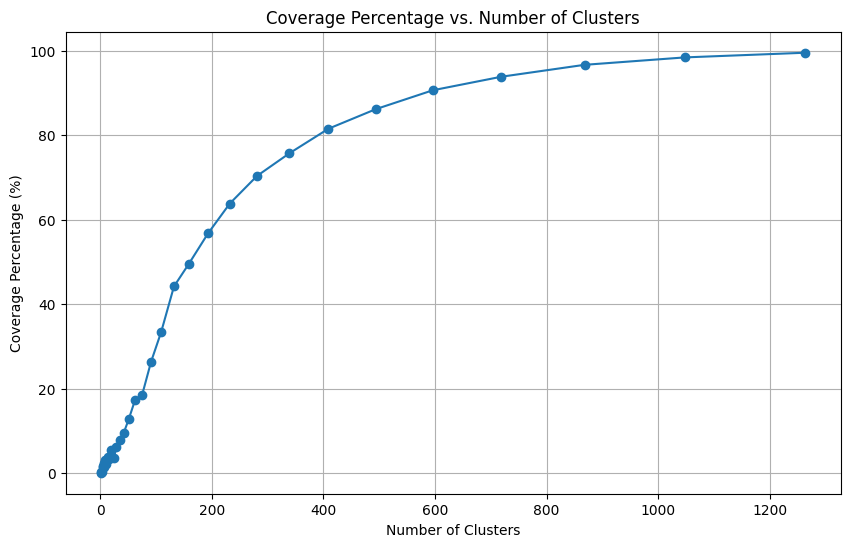

In [20]:
# Final plot of the number of clusters versus the coverage percentage
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range[:34], coverage_percentages[:34], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Coverage Percentage (%)')
plt.title('Coverage Percentage vs. Number of Clusters')
plt.grid(True)
plt.savefig(f"{figures_dir}/coverage_clusters_final.png")
plt.show()

In [14]:
n_clusters_range
coverage_percentages

[np.float64(0.11389521640091116),
 np.float64(0.292873413602343),
 np.float64(0.292873413602343),
 np.float64(1.561991539212496),
 np.float64(1.6108037748128863),
 np.float64(1.4480963228115846),
 np.float64(2.440611780019525),
 np.float64(3.058900097624471),
 np.float64(2.164009111617312),
 np.float64(3.9375203384315003),
 np.float64(3.254149040026033),
 np.float64(5.450699642043606),
 np.float64(3.6121054344288965),
 np.float64(6.117800195248942),
 np.float64(7.84249918646274),
 np.float64(9.550927432476406),
 np.float64(12.78880572730231),
 np.float64(17.214448421737714),
 np.float64(18.54864952814839),
 np.float64(26.374877969411),
 np.float64(33.37129840546697),
 np.float64(44.1750732183534),
 np.float64(49.593231369996744),
 np.float64(56.71981776765376),
 np.float64(63.781321184510254),
 np.float64(70.33843150016271),
 np.float64(75.69150667100554),
 np.float64(81.500162707452),
 np.float64(86.13732508948911),
 np.float64(90.59550927432475),
 np.float64(93.80084607875041),
 np.f